In [1]:
import torch
import numpy as np                          # Array creation & manipulation
import matplotlib.pyplot as plt             # Plotting
plt.style.use('default')            # Choose a plot style that suits your environment ('default', 'classic', 'dark_background')
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
import torch.nn as nn
import torchvision
from torchvision.transforms import CenterCrop as Crop
import gc
import random
import copy
import torch.optim as optim
import time
import pickle

In [ ]:
#collect the training results and merge them 
b_sizes=[6,8,10,12,14,16]
counts=range(0,112)
h,b,t,v=[],[],[],[]
for b_size in b_sizes:
    for count in counts:
        with open(f'datas/RGBMLP_{b_size}_hyper_{count}.pickle','rb') as f:
            h.extend(copy.deepcopy(pickle.load(f)))
        with open(f'datas/RGBMLP_{b_size}_best_{count}.pickle','rb') as f:
            b.extend(copy.deepcopy(pickle.load(f)))
        with open(f'datas/RGBMLP_{b_size}_tr_{count}.pickle','rb') as f:
            t.extend(copy.deepcopy(pickle.load(f)))
        with open(f'datas/RGBMLP_{b_size}_val_{count}.pickle','rb') as f:
            v.extend(copy.deepcopy(pickle.load(f)))
with open(f'datas/RGBMLP_hyper.pickle','wb') as f:
    pickle.dump(h,f)
with open(f'datas/RGBMLP_best.pickle','wb') as f:
    pickle.dump(b,f)
with open(f'datas/RGBMLP_tr.pickle','wb') as f:
    pickle.dump(t,f)
with open(f'datas/RGBMLP_val.pickle','wb') as f:
    pickle.dump(v,f)


In [2]:
with open(f'datas/RGBMLP_hyper.pickle','rb') as f:
    h=pickle.load(f)
with open(f'datas/RGBMLP_best.pickle','rb') as f:
    b=pickle.load(f)
with open(f'datas/RGBMLP_tr.pickle','rb') as f:
    t=pickle.load(f)
with open(f'datas/RGBMLP_val.pickle','rb') as f:
    v=pickle.load(f)

In [51]:
Dsizes=[[3],[8],[16],[31],[4,8],[8,16],[16,32],[32,64],[64,32],[8,16,32],[16,32,64],
        [64,32,32],[128,64,32],[3,3,8,8],[4,8,16,32],[8,16,32,32],[64,64,32,32],[128,128,64,64]
        ,[256,128,64,32],[3,3,8,8,16,16],[8,8,16,16,32,32],[16,16,16,32,32,32],[16,16,32,32,64,64],
        [32,32,32,32,32,32],[64,64,64,32,32,32],[128,128,64,64,32,32],[256,256,128,128,64,64],[512,512,256,256,128,128]
]
bsizes=[6,8,10,12,14,16]
PSNR_=[]
T_=[]
O_=[]
V_=[]
R_=[]
TR_=[]
for Dsize in Dsizes:
    psnr_=[float('inf')]*len(bsizes)
    t_=[float('inf')]*len(bsizes)
    o_=[float('inf')]*len(bsizes)
    v_=[float('inf')]*len(bsizes)
    r_=[float('inf')]*len(bsizes)
    tr_=[float('inf')]*len(bsizes)
    for b_index in range(len(bsizes)):
        bsize=bsizes[b_index]
        for i in range(len(h)):
            if h[i]['batch_size']==int(2**bsize) and h[i]['Dsize']==Dsize:
                if b[i][1]<v_[b_index]:
                    v_[b_index]=b[i][1]
                    psnr_[b_index]=10*np.log10(1/b[i][2])
                    t_[b_index]=b[i][3]
                    o_[b_index]=(b[i][2]-b[i][0])/b[i][0]
                    r_[b_index]=h[i]['lr']
                    tr_[b_index]=[t[i],v[i]]
    PSNR_.append(copy.deepcopy(psnr_))
    T_.append(copy.deepcopy(t_))
    O_.append(copy.deepcopy(o_))
    R_.append(copy.deepcopy(r_))
    TR_.append(copy.deepcopy(tr_))
PSNR_,T_,O_,R_=np.array(PSNR_),np.array(T_),np.array(O_),np.array(R_)
np.save('datas/MLP_PSNR.npy',PSNR_)
np.save('datas/MLP_T.npy',T_)
np.save('datas/MLP_O.npy',O_)
np.save('datas/MLP_R.npy',R_)


PSNRmax=np.max(PSNR_,axis=1).reshape(-1,1)
PSNR_=np.hstack((PSNR_,PSNRmax))
indices=np.argsort(-PSNR_[:,-1])
# [Dsizes[indices[i]] for i in range(len(indices))],PSNR_[indices],R_[indices]

max_index=np.argmax(PSNR_)
row_in,col_in=np.unravel_index(max_index,PSNR_.shape)
bsizes[col_in],Dsizes[row_in],R_[row_in,col_in],PSNR_[row_in,col_in],O_[row_in,col_in], T_[row_in,col_in]

(6,
 [512, 512, 256, 256, 128, 128],
 0.0001,
 45.53884527929548,
 0.1836786401807537,
 3226.3991327285767)

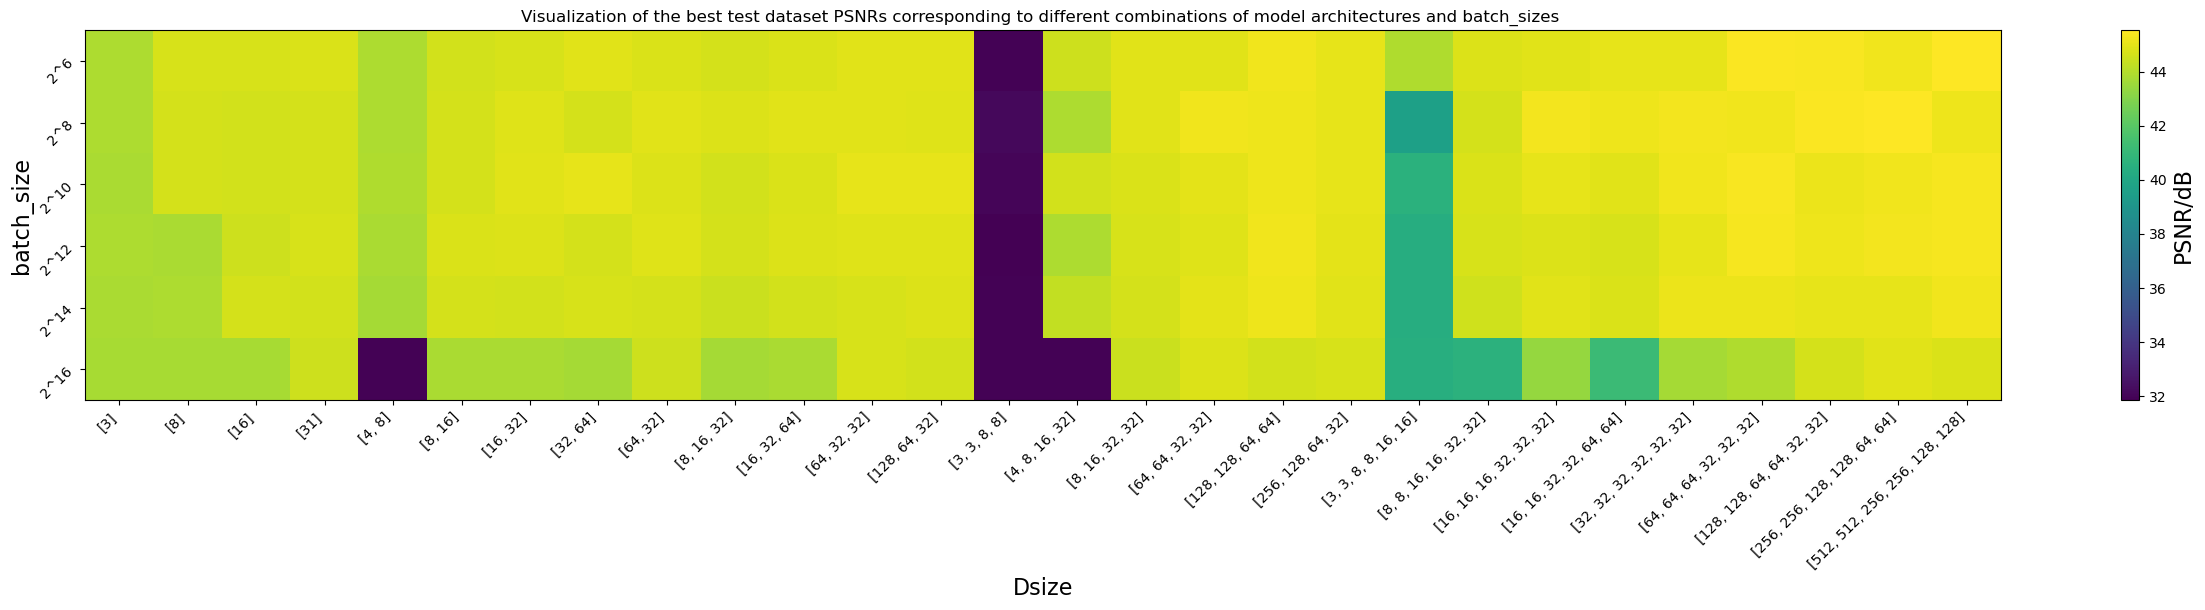

In [45]:
x_labels = [str(Dsize) for Dsize in Dsizes ]
y_labels = ['2^'+str(bsize) for bsize in bsizes ]
fig, ax = plt.subplots(figsize=(25, 6))
cax = ax.imshow(PSNR_[:,:-1].T, aspect='auto', cmap='viridis')
ax.set_xticks(np.arange(len(x_labels)))
ax.set_xticklabels(x_labels, rotation=45, ha='right')
ax.set_xlabel('Dsize',fontsize=16)

ax.set_yticks(np.arange(len(y_labels)))
ax.set_yticklabels(y_labels, rotation=45, ha='right')
ax.set_ylabel('batch_size',fontsize=16)


cbar = plt.colorbar(cax,ax=ax)
cbar.set_label('PSNR/dB',fontsize=16)
plt.tight_layout()
plt.savefig('datas/MLP_PSNR.png')
plt.title('Visualization of the best test dataset PSNRs corresponding to different combinations of model architectures and batch_sizes ')
plt.show()


In [49]:
for i in range(0,6):
    print(np.mean(T_[:,i]),np.std(T_[:,i]))

3743.4645370841026 2252.180952116885
2075.500153158392 1418.7924455513637
1736.0010876740728 1102.8975111799116
1988.5522379875183 1088.9138263624968
3911.288364154952 1810.680839225407
4685.707203575543 2415.3865702623966


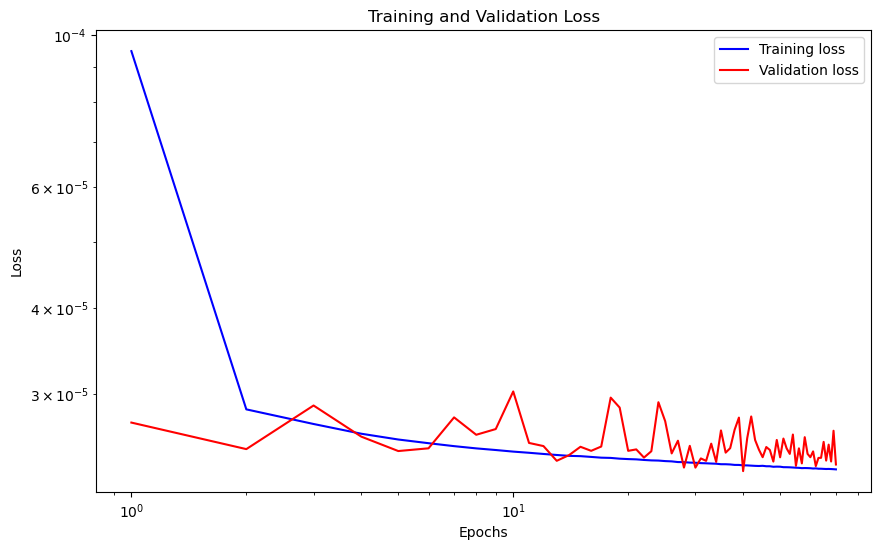

In [14]:
#plot the loss curve of both Training and Validation loss
tr_losses,val_losses=TR_[row_in][col_in]

total_epoch = range(1, len(tr_losses) + 1)
plt.figure(figsize=(10, 6))
plt.loglog(total_epoch , tr_losses, 'b', label='Training loss')
plt.loglog(total_epoch , val_losses, 'r', label='Validation loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')
# plt.ylim([-2.,+1.])
plt.legend()
plt.savefig('datas/MLP_his_best.png')
plt.title(f'Training and Validation Loss')
plt.show()

In [ ]:
Dsizes=[[31],[3],[16],[8],[4,8],[8,16],[16,32],[16,32,64],[3,3,8,8],[8,16,32,32],[4,8,16,32],[3,3,8,8,16,16],[8,8,16,16,32,32],[16,16,16,32,32,32],[16,16,32,32,64,64],[128,128,64,64,32,32],[32,64],[512,512,256,256,128,128],[8,16,32],[256,256,128,128,64,64],[64,64,64,32,32,32],[32,32,32,32,32,32],[128,128,64,64],[64,64,32,32],[256,128,64,32],[128,64,32],[64,32,32],[64,32]]
bsizes=[6,8,10,12,14,16]
R_results=[]
O_results=[]
for Dsize in Dsizes:
    b_results=[float('inf')]*len(bsizes)
    lr_results=[float('inf')]*len(bsizes)
    o_results=[float('inf')]*len(bsizes)
    for b_index in range(len(bsizes)):
        bsize=bsizes[b_index]
        for i in range(len(h)):
            if h[i]['batch_size']==int(2**bsize) and h[i]['Dsize']==Dsize:
                if b[i][2]<b_results[b_index]:
                    b_results[b_index]=b[i][2]
                    lr_results[b_index]=h[i]['lr']
                    o_results[b_index]=(b[i][2]-b[i][1])/b[i][1]
    R_results.append(copy.deepcopy(lr_results))
    O_results.append(copy.deepcopy(o_results))
R_results=np.array(R_results)
O_results=np.array(O_results)
R_results[indices],O_results[indices]



In [55]:
h,b,t,v=[],[],[],[]

for count in range(16):
    with open(f'datas/DE-CASSI_hyper_{count}.pickle','rb') as f:
        h.extend(copy.deepcopy(pickle.load(f)))
    with open(f'datas/DE-CASSI_best_{count}.pickle','rb') as f:
        b.extend(copy.deepcopy(pickle.load(f)))
    with open(f'datas/DE-CASSI_tr_{count}.pickle','rb') as f:
        t.extend(copy.deepcopy(pickle.load(f)))
    with open(f'datas/DE-CASSI_val_{count}.pickle','rb') as f:
        v.extend(copy.deepcopy(pickle.load(f)))
with open(f'datas/DE-CASSI_hyper.pickle','wb') as f:
    pickle.dump(h,f)
with open(f'datas/DE-CASSI_best.pickle','wb') as f:
    pickle.dump(b,f)
with open(f'datas/DE-CASSI_tr.pickle','wb') as f:
    pickle.dump(t,f)
with open(f'datas/DE-CASSI_val.pickle','wb') as f:
    pickle.dump(v,f)

b=np.array(b)
min_in=np.argmin(b[:,1]).item()
h[min_in],b[min_in]

({'Cnums': [128, 256, 512, 1024, 2048], 'lr': 0.0001, 'w_d': 6e-05},
 array([1.25773235e-03, 1.02973349e-03, 6.24973327e-04, 9.86168385e+02,
        1.24154783e+08, 2.57000000e+02, 2.95000000e+02]))

In [56]:
#collect the training results and merge them 
b_sizes = [6,8,10,12,14,16,18]
counts = range(0, 112)
h, b, t, v = [], [], [], []

for b_size in b_sizes:
    for count in counts:
        try:
            with open(f'datas/RGBPINN_{b_size}_hyper_{count}.pickle', 'rb') as f:
                h.extend(copy.deepcopy(pickle.load(f)))
        except FileNotFoundError:
            pass
        
        try:
            with open(f'datas/RGBPINN_{b_size}_best_{count}.pickle', 'rb') as f:
                b.extend(copy.deepcopy(pickle.load(f)))
        except FileNotFoundError:
            pass
        
        try:
            with open(f'datas/RGBPINN_{b_size}_tr_{count}.pickle', 'rb') as f:
                t.extend(copy.deepcopy(pickle.load(f)))
        except FileNotFoundError:
            pass
        
        try:
            with open(f'datas/RGBPINN_{b_size}_val_{count}.pickle', 'rb') as f:
                v.extend(copy.deepcopy(pickle.load(f)))
        except FileNotFoundError:
            pass
with open(f'datas/RGBPINN_hyper.pickle','wb') as f:
    pickle.dump(h,f)
with open(f'datas/RGBPINN_best.pickle','wb') as f:
    pickle.dump(b,f)
with open(f'datas/RGBPINN_tr.pickle','wb') as f:
    pickle.dump(t,f)
with open(f'datas/RGBPINN_val.pickle','wb') as f:
    pickle.dump(v,f)


In [79]:
alphas=[]
for i in range(len(h)):
    if h[i]['alpha'] not in alphas:
        alphas.append(h[i]['alpha'])
alphas.pop(-4)
alphas

[0.03162277660168379,
 0.1606506003853728,
 0.8161400793251826,
 1.4030037231905734,
 4.146169559796819,
 12.25279857382865,
 21.063445423241202,
 107.00689556931746]

In [80]:
Dsizes=[[512,512,256,256,128,128],[16, 16, 32, 32, 64, 64]]
DsizesMLP=[[3],[8],[16],[31],[4,8],[8,16],[16,32],[32,64],[64,32],[8,16,32],[16,32,64],
        [64,32,32],[128,64,32],[3,3,8,8],[4,8,16,32],[8,16,32,32],[64,64,32,32],[128,128,64,64]
        ,[256,128,64,32],[3,3,8,8,16,16],[8,8,16,16,32,32],[16,16,16,32,32,32],[16,16,32,32,64,64],
        [32,32,32,32,32,32],[64,64,64,32,32,32],[128,128,64,64,32,32],[256,256,128,128,64,64],[512,512,256,256,128,128]
]
PSNR0=torch.zeros((2,1))
T0=torch.zeros((2,1))
for i in range(len(Dsizes)):
    for j in range(len(DsizesMLP)):
        if DsizesMLP[j]==Dsizes[i]:
            max_in=np.argmax(PSNR_[j][:6])
            PSNR0[i][0]=PSNR_[j][max_in]
            T0[i][0]=T_[j][max_in]

PSNRP_=[]
TP_=[]
for Dsize in Dsizes:
    psnr_=[float('inf')]*len(alphas)
    t_=[float('inf')]*len(alphas)
    v_=[float('inf')]*len(alphas)
    for b_index in range(len(alphas)):
        bsize=alphas[b_index]
        for i in range(len(h)):
            if h[i]['alpha']==bsize and h[i]['Dsize']==Dsize:
                if b[i][1]<v_[b_index]:
                    v_[b_index]=b[i][1]
                    psnr_[b_index]=10*np.log10(1/b[i][5])
                    t_[b_index]=b[i][6]
    PSNRP_.append(copy.deepcopy(psnr_))
    TP_.append(copy.deepcopy(t_))

PSNRP_,TP_=np.array(PSNRP_),np.array(TP_)
PSNRP_=np.hstack((PSNR0, PSNRP_))
TP_=np.hstack((T0, TP_))



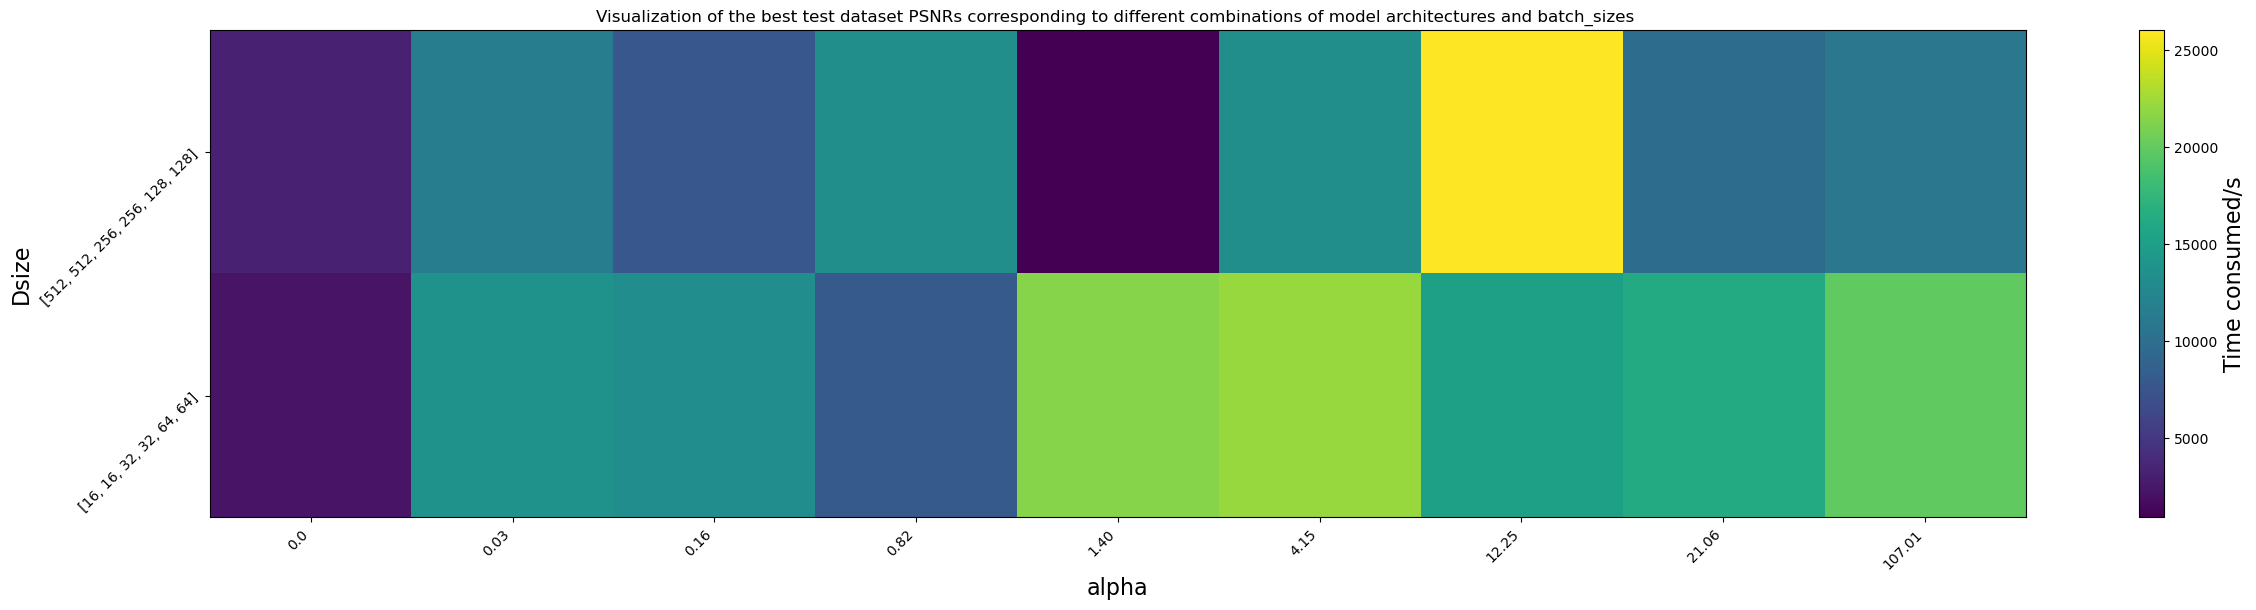

In [82]:
y_labels = [str(Dsize) for Dsize in Dsizes ]
x_labels = [format(alpha,".2f") for alpha in alphas ]
x_labels=['0.0']+x_labels
fig, ax = plt.subplots(figsize=(25, 6))
cax = ax.imshow(TP_, aspect='auto', cmap='viridis')
ax.set_xticks(np.arange(len(x_labels)))
ax.set_xticklabels(x_labels, rotation=45, ha='right')
ax.set_xlabel('alpha',fontsize=16)

ax.set_yticks(np.arange(len(y_labels)))
ax.set_yticklabels(y_labels, rotation=45, ha='right')
ax.set_ylabel('Dsize',fontsize=16)


cbar = plt.colorbar(cax,ax=ax)
cbar.set_label('Time consumed/s',fontsize=16)
plt.tight_layout()
plt.savefig('datas/PINN_T.png')
plt.title('Visualization of the best test dataset PSNRs corresponding to different combinations of model architectures and batch_sizes ')
plt.show()


In [83]:
devi_PINN_MSE=[]
for i in range(len(b)):
    devi_PINN_MSE.append((b[i][2]-b[i][5])/b[i][2])
devi=np.array(devi_PINN_MSE) 
np.mean(devi),np.std(devi)

(0.012727454346939159, 0.01548182669787574)